# Binary image classification
> On a simple image dataset
- order: 4
- image: covers/binary_image_classification_cover.png
- callout-appearance: simple
- toc-depth: 2

Here we'll take a problem of binary image classifing.

In [1]:
#|code-fold: true
#|output: false
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from pytorched.step_by_step import StepByStep
import platform
from PIL import Image
import datetime
import matplotlib.pyplot as plt
from matplotlib import cm
from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler, SubsetRandomSampler
from torchvision.transforms import Compose, ToTensor, Normalize, ToPILImage, RandomHorizontalFlip, Resize

plt.style.use('fivethirtyeight')

%load_ext autoreload
%autoreload 2

In [2]:
#|code-fold: true 
def show_image(im, cmap=None):
    fig = plt.figure(figsize=(3,3))
    plt.imshow(im, cmap=cmap)
    plt.grid(False)
    plt.show()

# Data

We'll use generated data, where images with horizontal and vertical lines are considered label `0`, while diagonal have label `1`.

In [3]:
#|code-fold: true
def gen_img(start, target, fill=1, img_size=10):
    # Generates empty image
    img = np.zeros((img_size, img_size), dtype=float)

    start_row, start_col = None, None

    if start > 0:
        start_row = start
    else:
        start_col = np.abs(start)

    if target == 0:
        if start_row is None:
            img[:, start_col] = fill
        else:
            img[start_row, :] = fill
    else:
        if start_col == 0:
            start_col = 1
        
        if target == 1:
            if start_row is not None:
                up = (range(start_row, -1, -1), 
                      range(0, start_row + 1))
            else:
                up = (range(img_size - 1, start_col - 1, -1), 
                      range(start_col, img_size))
            img[up] = fill
        else:
            if start_row is not None:
                down = (range(start_row, img_size, 1), 
                        range(0, img_size - start_row))
            else:
                down = (range(0, img_size - 1 - start_col + 1), 
                        range(start_col, img_size))
            img[down] = fill
    
    return 255 * img.reshape(1, img_size, img_size)


def generate_dataset(img_size=10, n_images=100, binary=True, seed=17):
    np.random.seed(seed)

    starts = np.random.randint(-(img_size - 1), img_size, size=(n_images,))
    targets = np.random.randint(0, 3, size=(n_images,))
    
    images = np.array([gen_img(s, t, img_size=img_size) 
                       for s, t in zip(starts, targets)], dtype=np.uint8)
    
    if binary:
        targets = (targets > 0).astype(int)
    
    return images, targets

def plot_images(images, targets, n_plot=30):
    n_rows = n_plot // 6 + ((n_plot % 6) > 0)
    fig, axes = plt.subplots(n_rows, 6, figsize=(9, 1.5 * n_rows))
    axes = np.atleast_2d(axes)
    
    for i, (image, target) in enumerate(zip(images[:n_plot], targets[:n_plot])):
        row, col = i // 6, i % 6    
        ax = axes[row, col]
        ax.set_title('#{} - Label:{}'.format(i, target), {'size': 12})
        # plot filter channel in grayscale
        ax.imshow(image.squeeze(), cmap='gray', vmin=0, vmax=1)

    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.label_outer()

    plt.tight_layout()
    return fig

In [4]:
images, labels = generate_dataset(img_size=5, n_images=300, binary=True, seed=13)

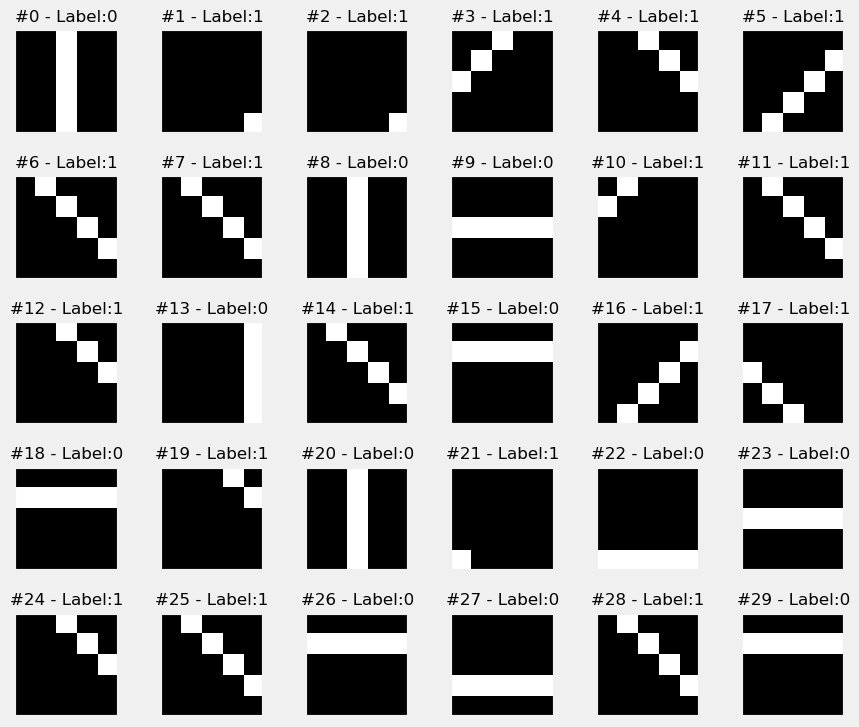

In [5]:
fig = plot_images(images, labels, n_plot=30)

# Data preparation

In [6]:
x_tensor = torch.as_tensor(images / 255.).float()
y_tensor = torch.as_tensor(labels.reshape(-1, 1)).float()  # reshaped this to (N,1) tensor

PyTorch has `Dataset` class, `TensorDataset` as a subclass, and we can create custom subclasses too that can handle **data augmentation**:

In [7]:
class TransformedTensorDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.x[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, self.y[index]
        
    def __len__(self):
        return len(self.x)

A `torch.utils.data.random_split` method can split indices into train and valid (it requires exact number of images to split):

In [8]:
torch.manual_seed(13)
N = len(x_tensor)
n_train = int(.8*N)
n_val = N - n_train
train_subset, val_subset = random_split(x_tensor, [n_train, n_val])
train_subset

we just need indices:

In [9]:
train_idx = train_subset.indices
val_idx = val_subset.indices

In [10]:
train_idx[:10]

[118, 170, 148, 239, 226, 146, 168, 195, 6, 180]

# Data augmentation

For data augmentation we only augment training data, so we create training and validation **Composer**:

In [11]:
train_composer = Compose([RandomHorizontalFlip(p=.5),
                          Normalize(mean=(.5,), std=(.5,))])

val_composer = Compose([Normalize(mean=(.5,), std=(.5,))])

Now we can build train/val `tensors`, `Dataset`s and `DataLoader`s:

In [12]:
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]

x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

train_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor, transform=train_composer)
val_dataset = TransformedTensorDataset(x_val_tensor, y_val_tensor, transform=val_composer)

We could stop here and just make loaders:

In [13]:
# Builds a loader of each set
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

or we can even used `WeightedRandomSampler` if we want to balance datasets:

In [14]:
def make_balanced_sampler(y):
    # Computes weights for compensating imbalanced classes
    classes, counts = y.unique(return_counts=True)
    weights = 1.0 / counts.float()
    sample_weights = weights[y.squeeze().long()]
    # Builds sampler with compute weights
    generator = torch.Generator()
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        generator=generator,
        replacement=True
    )
    return sampler

Note that we don't need a `val_sampler` anymore since we already split datasets:

In [15]:
train_sampler = make_balanced_sampler(y_train_tensor)

In [16]:
train_loader = DataLoader(dataset=train_dataset, batch_size=16, sampler=train_sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)  

In [17]:
#| hide
len(iter(train_loader)), len(iter(val_loader))

(15, 4)

# Logistic Regression Model

In [18]:
lr = 0.1

# Now we can create a model
model_logistic = nn.Sequential()
model_logistic.add_module('flatten', nn.Flatten())
model_logistic.add_module('output', nn.Linear(25, 1, bias=True))
model_logistic.add_module('sigmoid', nn.Sigmoid())

# Defines a SGD optimizer to update the parameters 
optimizer_logistic = optim.SGD(model_logistic.parameters(), lr=lr)

# Defines a binary cross entropy loss function
binary_loss_fn = nn.BCELoss()

In [19]:
sbs_logistic = StepByStep(model_logistic, optimizer_logistic, binary_loss_fn)
sbs_logistic.set_seed()
sbs_logistic.set_loaders(train_loader, val_loader)
sbs_logistic.train(200)

Failed to set loader seed.


100%|██████████| 200/200 [00:08<00:00, 23.24it/s]


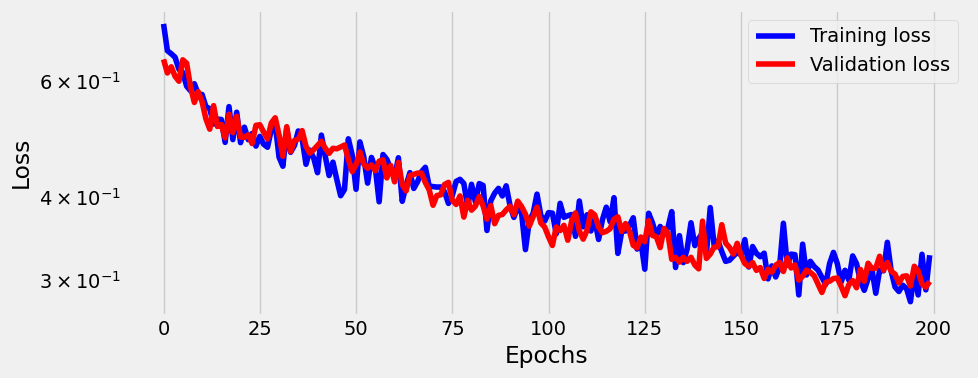

In [20]:
fig = sbs_logistic.plot_losses()

In [21]:
#|code-fold: true
print('Correct categories:')
print(sbs_logistic.loader_apply(sbs_logistic.val_loader, sbs_logistic.correct))

Correct categories:
tensor([[24, 24],
        [34, 36]])


After 200 epoch it's almost 100%. Let's add 400 more:

In [22]:
sbs_logistic.train(400)

100%|██████████| 400/400 [00:13<00:00, 29.00it/s]


In [23]:
#|code-fold: true
print('Correct categories:')
print(sbs_logistic.loader_apply(sbs_logistic.val_loader, sbs_logistic.correct))

Correct categories:
tensor([[24, 24],
        [36, 36]])


so after 600 epoch model is 100% accurate (at least on 60 samples).

# Deeper Model

In [ ]:
lr = 0.1

# Now we can create a model
model_deeper = nn.Sequential()
model_deeper.add_module('flatten', nn.Flatten())
model_deeper.add_module('linear1', nn.Linear(25, 10, bias=True))
model_deeper.add_module('relu', nn.ReLU())
model_deeper.add_module('linear2', nn.Linear(10, 1, bias=True))
model_deeper.add_module('sigmoid', nn.Sigmoid())

# Defines a SGD optimizer to update the parameters 
optimizer_deeper = optim.SGD(model_deeper.parameters(), lr=lr)

# Defines a binary cross entropy loss function
binary_loss_fn = nn.BCELoss()

In [ ]:
sbs_deeper = StepByStep(model_deeper, optimizer_deeper, binary_loss_fn)
sbs_deeper.set_seed()
sbs_deeper.set_loaders(train_loader, val_loader)
sbs_deeper.train(20)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 28.33it/s]


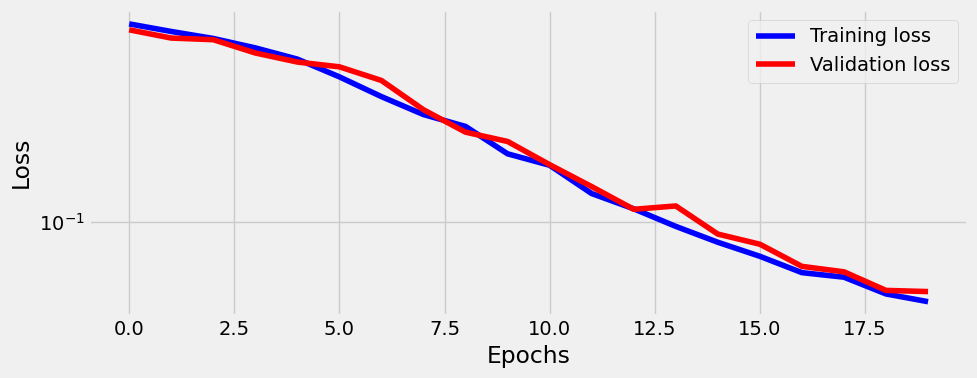

In [ ]:
fig = sbs_deeper.plot_losses()

In [ ]:
#|code-fold: true
print('Correct categories:')
print(sbs_deeper.loader_apply(sbs_deeper.val_loader, sbs_deeper.correct))    

Correct categories:
tensor([[24, 24],
        [36, 36]])


and even after 20 epoch it's 100% accurate. We can train more to flatten the loss though which will surely generalize model:

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:06<00:00, 30.26it/s]


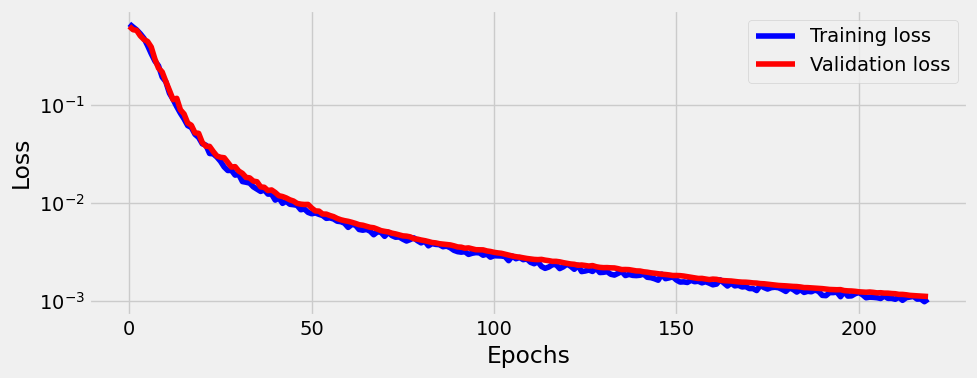

In [ ]:
sbs_deeper.train(200)
fig = sbs_deeper.plot_losses()

And that's it.